In [2]:
from enum import Enum

import numpy as np
import scipy.stats
import pandas
import matplotlib.pyplot as plt
import sklearn.linear_model
from matplotlib.lines import Line2D
import functools

def draw(ax, shs, bshs, lo, hi):
    ax.hist(shs, bins=bshs, density=True)
    ax.add_line(Line2D([lo, lo], ax.get_ylim(), linewidth=1, linestyle='--'))
    ax.add_line(Line2D([hi, hi], ax.get_ylim(), linewidth=1, linestyle='--'))

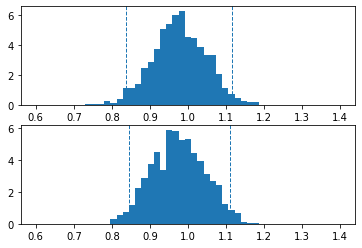

In [72]:
# Question 1
mu = 1
s = 1
n = 100

f = functools.partial(scipy.stats.norm.rvs, loc=mu, scale=s)
xs = [f() for _ in range(n)]  # generate dataset

ss = 1000  # resample size


def muh(xs):  # mu hat
    return np.average(xs)


def sh(xs):  # sigma hat
    return np.sqrt(1 / len(xs) * np.sum((xs - muh(xs)) ** 2))


def para(xs, sz):
    muhv = muh(xs)
    shv = sh(xs)
    g = functools.partial(scipy.stats.norm.rvs, loc=muhv, scale=shv)
    return [[g() for _ in range(len(xs))] for _ in range(sz)]


def nonpara(xs, sz):
    return [[np.random.choice(xs) for _ in range(len(xs))] for _ in range(sz)]


ys, zs = map(lambda x: x(xs, ss), [para, nonpara])  # generate parametric/non-parametric datasets
ysshs, zsshs = map(lambda xs: np.array(sorted(list(map(sh, xs)))), [ys, zs])  # calculate std dev

fig1, (ax11, ax12) = plt.subplots(2, 1)
bshs = np.linspace(0.6, 1.4, 50)


def draw2(ax, shs, bshs):
    lo, hi = shs[int(len(shs) * 0.025)], shs[int(len(shs) * 0.975)]
    draw(ax, shs, bshs, lo, hi)

draw2(ax11, ysshs, bshs)
draw2(ax12, zsshs, bshs)

plt.show()

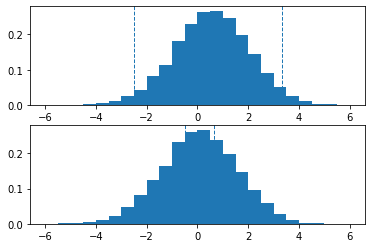

p-value: 0.6988


'calculate the probability that we obtained our current result.'

In [19]:
# Question 2
"""
While looking through this question again, I realised
there is a shortcut: vhat-muhat is again a poisson rv,
so I could have directly calculated the 95% confidence
interval values without any code
"""

xs = [3, 1, 5]
ys = [2, 3]

ss = 10000  # sample size


def lh(bs):  # lambda hat
    return np.sum(bs) / len(bs)


def vmu(vs, us):  # v minus u
    return lh(vs) - lh(us)


xlh, ylh = map(lh, [xs, ys])  # x lambda hat, y lambda hat


def g(mu):  # generate one rv
    return scipy.stats.poisson.rvs(mu=mu)


def gd(xlh, xs, ylh, ys, ss):  # generate dataset
    return [([g(xlh) for _ in range(len(xs))], [g(ylh) for _ in range(len(ys))]) for _ in range(ss)]


ds = gd(xlh, xs, ylh, ys, ss)

# calculate v minus u for all data
vmuds = np.array(sorted(list(map(lambda x: vmu(*x), ds))))

lo, hi = vmuds[int(len(vmuds) * 0.025)], vmuds[int(len(vmuds) * 0.975)]

fig2, (ax21, ax22) = plt.subplots(2, 1)
bvmuds = np.linspace(-6, 6, 25)
draw(ax21, vmuds, bvmuds, lo, hi)

xylh = lh(xs + ys)  # x and y (combined) lambda hat
vmuv = vmu(xs, ys)  # v hat minus u hat value
ds2 = gd(xylh, xs, xylh, ys, ss)  # dataset 2 for null hypothesis testing
vmuds2 = np.array(sorted(list(map(lambda x: vmu(*x), ds2))))
l = min(len(vmuds2[vmuds2 < vmuv]), len(vmuds2[vmuds2 > vmuv]))  # get tail length
lo, hi = vmuds2[l], vmuds2[-l]  # use a 2-sided tail
draw(ax22, vmuds2, bvmuds, lo, hi)
plt.show()
print(f'p-value: {2 * l / ss}')
'For the confidence interval, we assume that there is a difference, '
'and then try to estimate what that difference could have been. For '
'the hypothesis test, we assume that there is no difference, and '
'calculate the probability that we obtained our current result.'

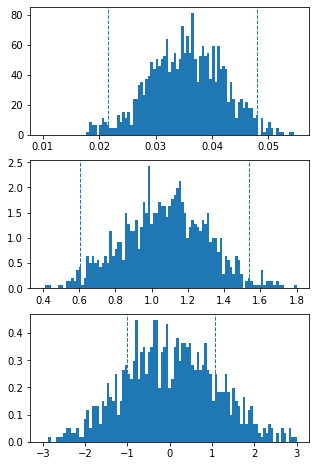

p-value: 0.356


In [10]:
# Question 3
url = 'https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/climate.csv'
climate = pandas.read_csv(url)
climate = climate.loc[(climate.station == 'Cambridge') & (climate.yyyy >= 1985)].copy()
t = climate.yyyy + (climate.mm - 1) / 12
temp = (climate.tmin + climate.tmax) / 2

cols = [np.sin(2 * np.pi * t), np.cos(2 * np.pi * t), t - 2000]
X = np.column_stack(cols)
model = sklearn.linear_model.LinearRegression()

def fit(X, temp):
    model.fit(X, temp)
    return model.intercept_, *list(model.coef_)

a, b1, b2, c = fit(X, temp)
tempnew = model.predict(X)

def g():  # generate new dataset, calculate sigma
    s = np.sqrt(1 / len(temp) * np.sum((temp - tempnew) ** 2))
    return tempnew + scipy.stats.norm.rvs(scale=s, size=len(tempnew))

ss = 1000

cs = sorted([fit(X, g())[3] for _ in range(ss)])
lo, hi = cs[int(len(cs) * 0.025)], cs[int(len(cs) * 0.975)]
fig3, (ax31, ax32, ax33) = plt.subplots(3, 1, figsize=(5, 8))
bs = np.linspace(0.01, 0.055, 100)
draw(ax31, cs, bs, lo, hi)

model = sklearn.linear_model.LinearRegression(fit_intercept=False)
cols2 = list(map(lambda x: np.where((x[0] <= t) & (t < x[1]), 1, 0), [(x, x + 10) for x in range(1980, 2021, 10)]))
X = np.column_stack(cols[:-1] + cols2)
def gmg(ps):  # gamma minus gamma, takes in params
    return ps[6] - ps[3]
csgmg = gmg(fit(X, temp))  # gamma minus gamma for climate data
tempnew = model.predict(X)
cs2 = sorted([gmg(fit(X, g())) for _ in range(ss)])
lo, hi = cs2[int(len(cs2) * 0.025)], cs2[int(len(cs2) * 0.975)]
bs2 = np.linspace(0.4, 1.8, 100)
draw(ax32, cs2, bs2, lo, hi)

c1980, c2010 = cols2[0], cols2[3]
cols3 = cols2.copy()
cols3[0] = c1980 & c2010
cols3.pop(3)
X2 = np.column_stack(cols[:-1] + cols3)
fit(X2, temp)
tempnew = model.predict(X2)

cs3 = np.array(sorted([gmg(fit(X, g())) for _ in range(ss)]))
l = min(len(cs3[cs3 < csgmg]), len(cs3[cs3 > csgmg]))  # get tail length
lo, hi = cs3[l], cs3[-l]
bs3 = np.linspace(-3, 3, 100)
draw(ax33, cs3, bs3, lo, hi)
plt.show()
print(f'p-value: {2 * l / ss}')